# Age and Gender Detection System.

### In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [1]:
# Import necessary modules first.
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import random
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
from pathlib import Path
warnings.filterwarnings('ignore')
%matplotlib inline

# Load the dataset

In [2]:
BASE_DIR = 'UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

# Data preprocessing

In [3]:
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image_path,age,gender
0,UTKFace\21_0_1_20170116214828919.jpg.chip.jpg,21,0
1,UTKFace\40_0_0_20170116233131287.jpg.chip.jpg,40,0
2,UTKFace\26_1_4_20170117201855518.jpg.chip.jpg,26,1
3,UTKFace\2_0_4_20161221202237961.jpg.chip.jpg,2,0
4,UTKFace\25_1_1_20170116175304948.jpg.chip.jpg,25,1


In [4]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [5]:
df.shape

(23708, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  23708 non-null  object
 1   age         23708 non-null  int64 
 2   gender      23708 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 555.8+ KB


In [7]:
df.describe()

,age,gender
count,23708.000000,23708.000000
mean,33.303484,0.477349
std,19.886112,0.499497
min,1.000000,0.000000
25%,23.000000,0.000000
50%,29.000000,0.000000
75%,45.000000,1.000000
max,116.000000,1.000000


In [8]:
df.isnull().sum()

image_path    0
age           0
gender        0
dtype: int64

# Exploratory Data Analysis

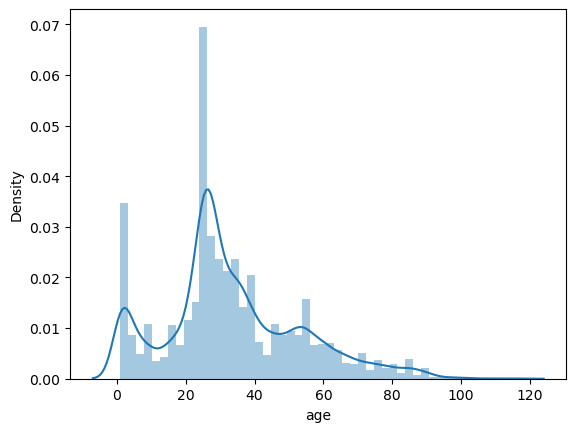

In [9]:
sns.distplot(df['age'])
plt.show()

In [10]:
df['gender'].value_counts()

0    12391
1    11317
Name: gender, dtype: int64

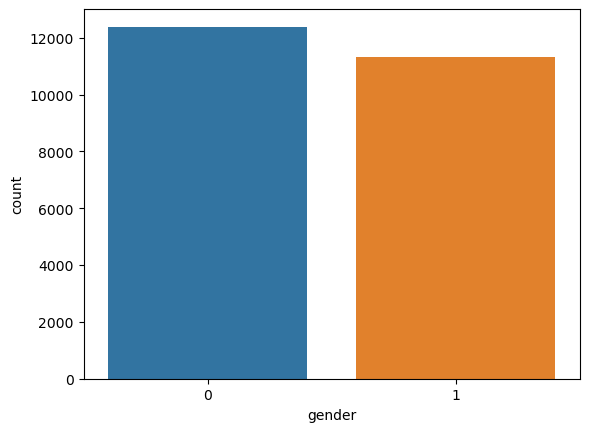

In [11]:
sns.countplot(data=df, x='gender')
plt.show()

The number of samples for females are slightly less than that of males. However, the dataset is not highly imbalanced.

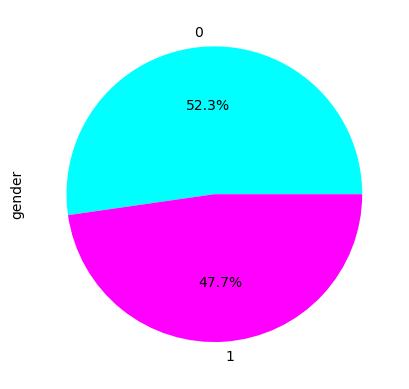

In [12]:
df['gender'].value_counts().plot(kind='pie',autopct="%.1f%%", colormap='cool');

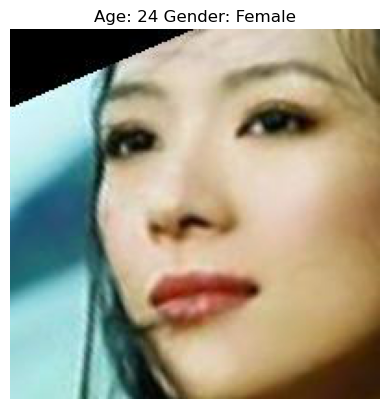

In [13]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

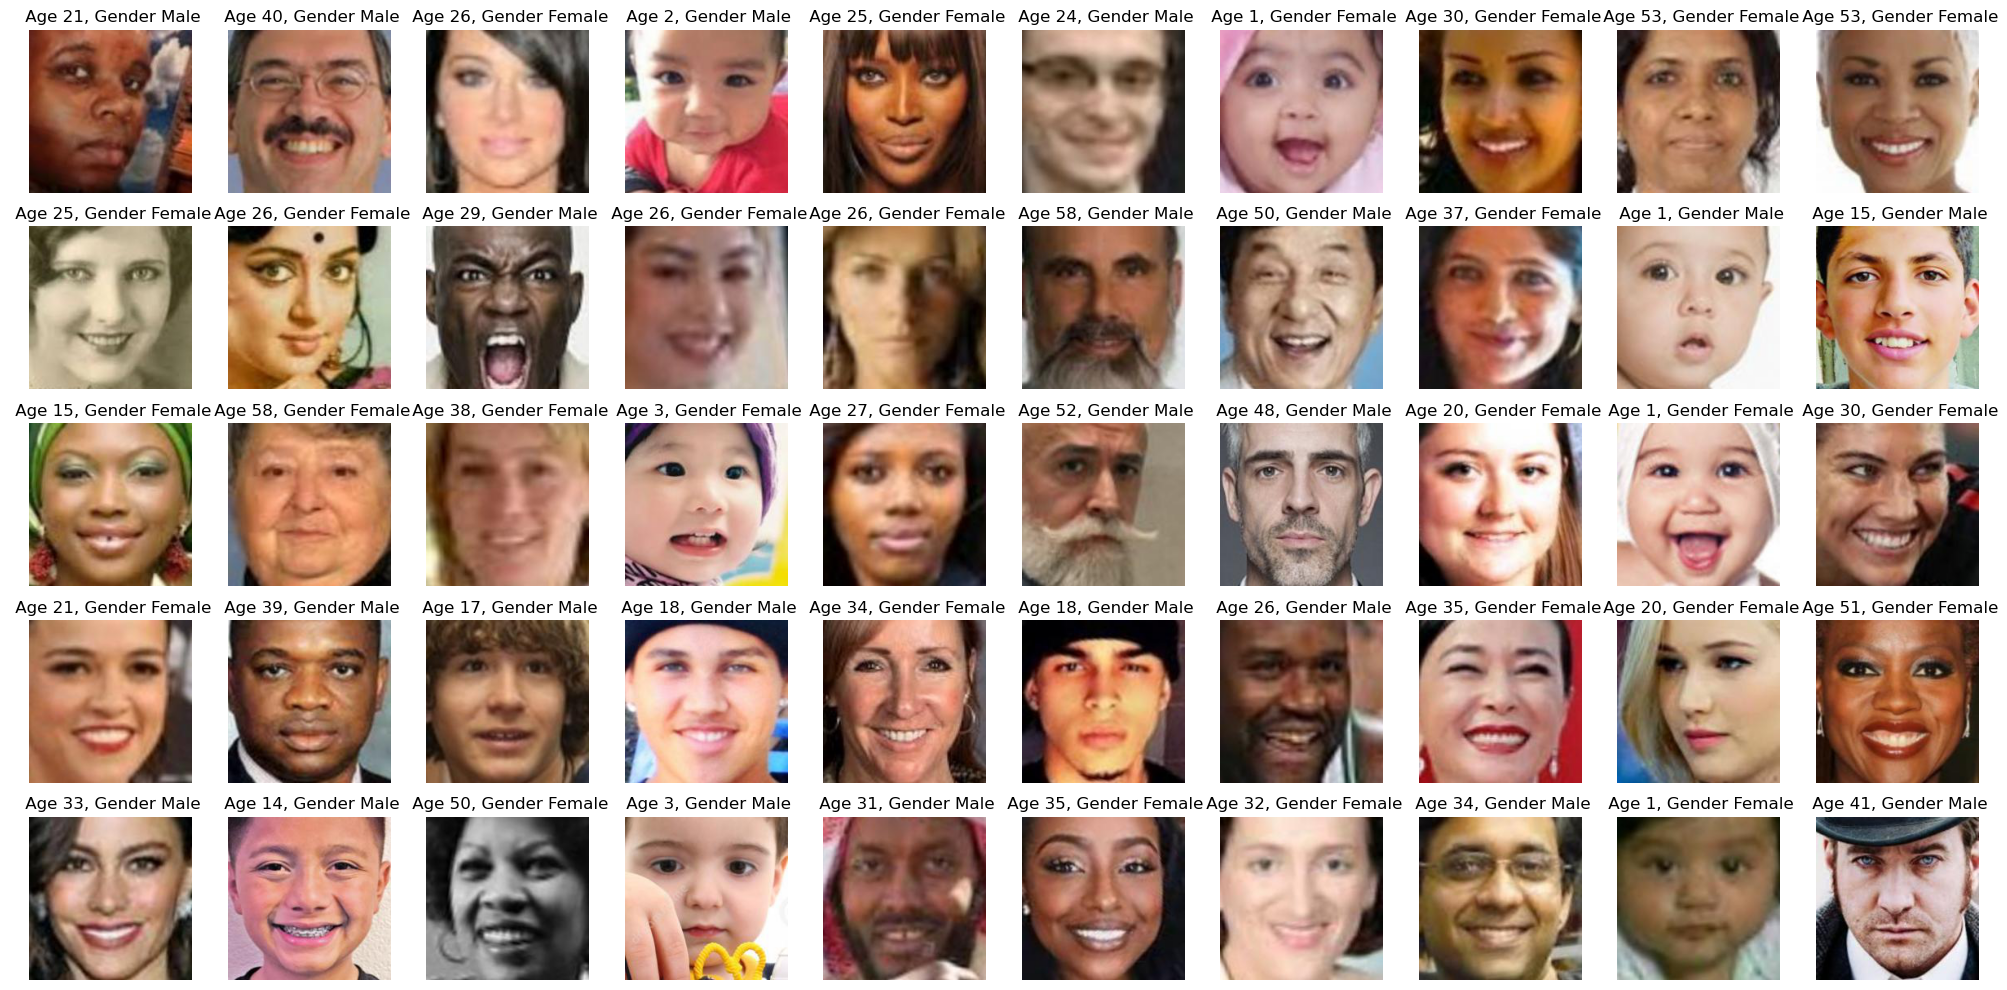

In [14]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
for i in range (50):
    plt.subplot(5,10,i+1)
    img = Image.open(df['image_path'][i])
    plt.title(f' Age {df.age[i]}, Gender {gender_mapping[df.gender[i]]}')
    plt.imshow(img);
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img

# Feature Extraction

In [16]:
#Converting Image to numpy array (extracting feature)
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [17]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [18]:
X.shape

(23708, 128, 128, 1)

#### Normalizing data

In [19]:
X = X/255.0

In [20]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [21]:
y_gender

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [22]:
y_age

array([21, 40, 26, ..., 32, 60, 19], dtype=int64)

In [23]:
print("y_gender Shape: "+ str(y_gender.shape))
print("y_age Shape: "+ str(y_age.shape))

y_gender Shape: (23708,)
y_age Shape: (23708,)


In [24]:
input_shape = (128, 128, 1)

### Building the CNN model

In [25]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [27]:
history = model.fit(x=X, y=[y_gender, y_age],batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
149/149 [==============================] - 169s 1s/step - loss: 16.9110 - gender_out_loss: 0.7449 - age_out_loss: 16.1662 - gender_out_accuracy: 0.5419 - age_out_accuracy: 0.0469 - val_loss: 15.0131 - val_gender_out_loss: 0.6657 - val_age_out_loss: 14.3473 - val_gender_out_accuracy: 0.6229 - val_age_out_accuracy: 0.0479
Epoch 2/10
149/149 [==============================] - 170s 1s/step - loss: 14.1662 - gender_out_loss: 0.5862 - age_out_loss: 13.5800 - gender_out_accuracy: 0.6920 - age_out_accuracy: 0.0464 - val_loss: 13.0050 - val_gender_out_loss: 0.5487 - val_age_out_loss: 12.4563 - val_gender_out_accuracy: 0.7265 - val_age_out_accuracy: 0.0363
Epoch 3/10
149/149 [==============================] - 199s 1s/step - loss: 11.7688 - gender_out_loss: 0.5064 - age_out_loss: 11.2623 - gender_out_accuracy: 0.7550 - age_out_accuracy: 0.0265 - val_loss: 10.8521 - val_gender_out_loss: 0.4626 - val_age_out_loss: 10.3895 - val_gender_out_accuracy: 0.7777 - val_age_out_accuracy: 0.0146
E

# Plot Results

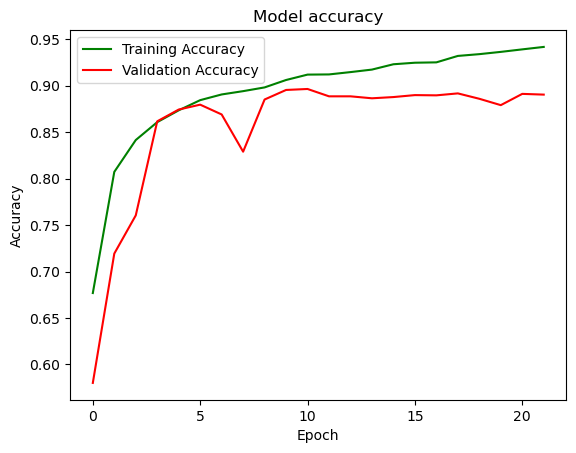

In [32]:
plt.plot(model_history.history['gender_output_accuracy'], 'green')
plt.plot(model_history.history['val_gender_output_accuracy'], 'red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

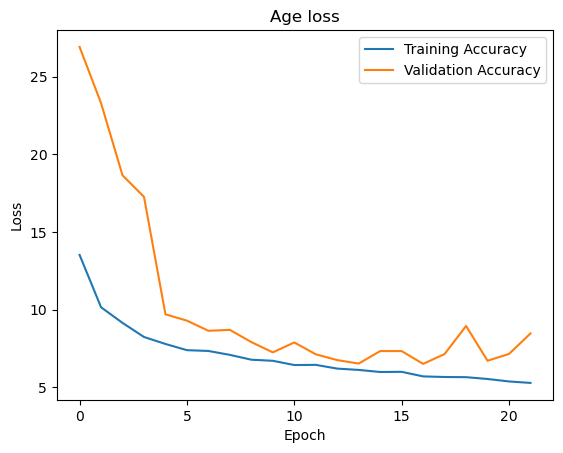

In [33]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

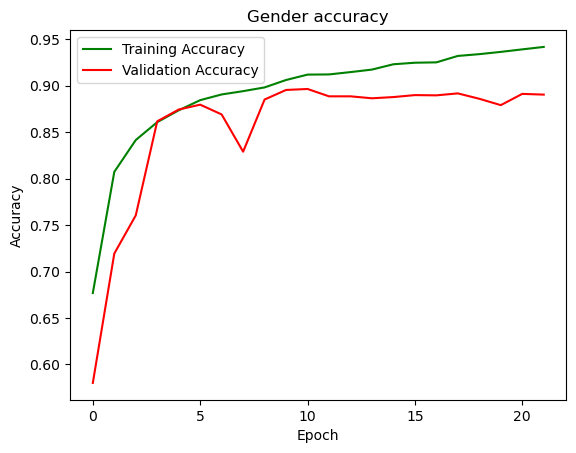

In [34]:
plt.plot(model_history.history['gender_output_accuracy'], 'green')
plt.plot(model_history.history['val_gender_output_accuracy'], 'red')
plt.title('Gender accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

#### Save the model

In [46]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)